/home/dtrad/anaconda3/envs/transformer/lib/python3.13/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 10, Loss: 0.2838
Epoch 20, Loss: 0.1325
Epoch 30, Loss: 0.0473
Epoch 40, Loss: 0.0310
Epoch 50, Loss: 0.0242
Epoch 60, Loss: 0.0185
Epoch 70, Loss: 0.0143
Epoch 80, Loss: 0.0122
Epoch 90, Loss: 0.0109
Epoch 100, Loss: 0.0100


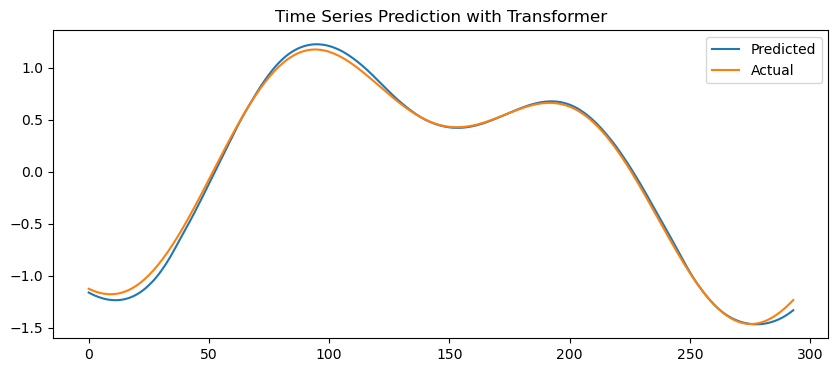

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# ---- Generate synthetic time series data ----
def generate_data(seq_len=1000):
    t = np.arange(0, seq_len)
    x = np.sin(0.02 * t) + 0.5 * np.sin(0.05 * t)
    return x

# ---- Create sliding windows for input/target ----
def create_dataset(series, input_len=20, pred_len=1):
    X, Y = [], []
    for i in range(len(series) - input_len - pred_len):
        X.append(series[i:i+input_len])
        Y.append(series[i+input_len:i+input_len+pred_len])
    return np.array(X), np.array(Y)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: [batch_size, seq_len, d_model]
        x = x + self.pe[:, :x.size(1)]
        return x




class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim=1, model_dim=64, num_heads=4, num_layers=2, dropout=0.1, max_len=500):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, model_dim)
        self.pos_encoder = PositionalEncoding(model_dim, max_len)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(model_dim, 1)

    def forward(self, x):
        # x: [batch, seq_len, 1]
        x = self.input_proj(x)  # [batch, seq_len, model_dim]
        x = self.pos_encoder(x)
        x = x.permute(1, 0, 2)  # [seq_len, batch, model_dim]
        x = self.transformer_encoder(x)
        x = x[-1]  # take last token
        return self.output_layer(x)


# ---- Main script ----
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Generate data
series = generate_data(1500)
input_len = 30
X, Y = create_dataset(series, input_len=input_len)

# Split
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1).to(device)
Y_train = torch.tensor(Y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1).to(device)
Y_test = torch.tensor(Y_test, dtype=torch.float32).to(device)

# Initialize model
model = TimeSeriesTransformer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# ---- Training loop ----
for epoch in range(100):
    model.train()
    output = model(X_train)
    loss = loss_fn(output.squeeze(), Y_train.squeeze())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# ---- Evaluation ----
model.eval()
with torch.no_grad():
    preds = model(X_test).squeeze().cpu().numpy()
    truth = Y_test.squeeze().cpu().numpy()

# ---- Plot predictions ----
plt.figure(figsize=(10, 4))
plt.plot(preds, label='Predicted')
plt.plot(truth, label='Actual')
plt.legend()
plt.title("Time Series Prediction with Transformer")
plt.show()
